In [ ]:
import torch
import torchvision
from torchvision import models
from torchvision import transforms
from torch import nn
import cv2
import numpy as np
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from PIL import Image
import random

if not os.path.isfile("ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "ilsvrc2012_wordnet_lemmas.txt")
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# GradCAM Function

In [ ]:
def unroll(module):
  if isinstance(module, torch.nn.modules.container.Sequential):
    return list(module.children())
  elif isinstance(module, torchvision.models.resnet.Bottleneck):
    return list(module.children())
  else:
    return [module]

def save_cnn_weights(module, cnn_weights, output):
  if isinstance(module, torch.nn.modules.conv.Conv2d):
    cnn_weights.append(output)
  return cnn_weights

In [ ]:
def gradCAM(img_path, model, class_idx=None, transform=None, save_heatmap=None, print_cls=True, print_pred=True):
    '''
    PARAMETERS
      img           : image for which grad-CAM will be plotted
      model         : model for which grad-CAM will be plotted
      class_idx     : (int) idx of the class for which grad-CAM will be plotted
                      If None, the default predicted class will be used. 
    '''
    img_orig = Image.open(img_path).convert('RGB')
    torch.manual_seed(0)
    random.seed(0)
    img = transform(img_orig) if transform else transforms.ToTensor()(img_orig)
    img = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True)  # give a batch size of 1
    output = img
    #if torch.cuda.is_available():
    #output.cuda()
    #model.cuda()

    cnn_i, sequential_i = 0, 0
    cnn_weights = []
    for module_pos, module in enumerate(model.children()):
      for i, m in enumerate(unroll(module)):
        if len(list(m.children())) == 0:
          output = m(output)
          cnn_weights = save_cnn_weights(m, cnn_weights, output)
          if isinstance(m, torch.nn.modules.pooling.AdaptiveAvgPool2d) :
            output = torch.flatten(output, 1)
        else:
          for ii, mm in enumerate(unroll(m)):
            output = mm(output)
            cnn_weights = save_cnn_weights(mm, cnn_weights, output)

    def forward_pass_on_convolutions(self, x):
        """ Does a forward pass on convolutions, hooks the function at given layer """
        conv_output = None
        for module_pos, (module_name, module) in enumerate(self.model._modules.items()):
            if module_pos < 9:
                x = module(x)  # Forward
                if int(module_pos) == self.target_layer:
                    x.register_hook(self.save_gradient)
                    conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    ### Step 1 ###
    # gradient of class c score (BEFORE softmax), wrt CNN feature map activations "layer weights"
    if class_idx is None:
      class_idx = torch.argmax(output, dim=-1).item()
    if print_cls:
      print("class:({})".format(class_idx), imagenet_labels[class_idx])
    #predicted
    cls_idx = torch.argmax(output, dim=-1)  
    if print_pred:
      print("predicted class:({})".format(cls_idx.item()), imagenet_labels[cls_idx.item()])
    grads = torch.autograd.grad(output[0, class_idx], cnn_weights[-1], retain_graph=True)
    grads = grads[0].squeeze(0)  # [n_filtermap, W_lastCNN, H_lastCNN]

    ### Step 2 ###
    grads_avgpooled = torch.mean(grads, axis=(1,2))  # [n_filtermap] 
    grads_avgpooled = grads_avgpooled.expand_as(cnn_weights[-1].squeeze(0).permute(1,2,0))
    grads_avgpooled = grads_avgpooled.permute(2,0,1)

    ### Step 3 : ReLU of Linear Combination ### 
    map = nn.ReLU()(grads_avgpooled*cnn_weights[-1].squeeze(0))   # layer_weights shape
    map = torch.sum(map, dim=0)  # [W_lastCNN, H_lastCNN]
    map = map.cpu().detach().numpy() if torch.cuda.is_available() else map.detach().numpy()
    map_interpolated = np.array(cv2.resize(map, dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC))

    ### Step 4 ###
    map_interpolated = cv2.resize(map, dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC)
    # make color heatmap
    heatmap = cv2.normalize(map_interpolated, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay heatmap on top of the image
    img_ = cv2.imread(img_path, 1)
    img_ = cv2.resize(img_, dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC)
    fin = cv2.addWeighted(img_, 0.3, heatmap, 0.7, 0)

    return class_idx, fin[:,:,::-1]

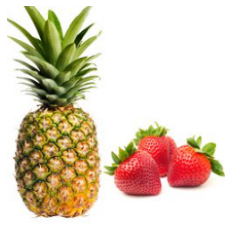

In [ ]:
plt.imshow(cv2.resize(plt.imread("ps.jpg"), (224,224)))
plt.show()
plt.imsave("orig.jpg", cv2.resize(plt.imread("ps.jpg"), (224,224)))

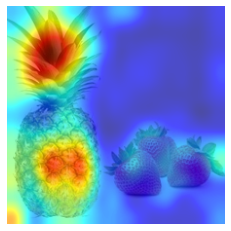

In [ ]:
predicted_cls, heatmap = gradCAM("ps.jpg", model=models.alexnet(pretrained=True), class_idx=953, transform=transform, print_cls=False, print_pred=False)
plt.imshow(heatmap)
plt.show()
plt.imsave("pine.jpg", heatmap)

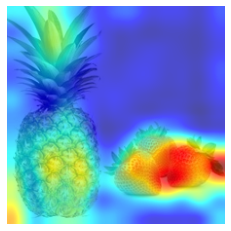

In [ ]:
predicted_cls, heatmap = gradCAM("ps.jpg", model=models.alexnet(pretrained=True), class_idx=949, transform=transform, print_cls=False, print_pred=False)
plt.imshow(heatmap)
plt.show()
plt.imsave("straw.jpg", heatmap)

# SmoothGrad Function

In [ ]:
def calcImageGrad(image_tensor, model, cls=None):
  image = image_tensor
  model.eval()
  image.requires_grad_()
  output = model(image)#.cuda())
  output_max_index = output[0].argmax() if cls==None else cls
  #print(output[0])
  output_max = output[0, output_max_index]
  output_max.backward()

  return torch.max(image.grad.data.abs(), dim=1)[0]

  
def smoothGrad(img_path, stdev, n, model, cls=None, return_heatmap=False, plot=True):
  image = Image.open(img_path)
  preprocessing = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  no_norm = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()
  ])
  image_processed = preprocessing(image)
  image_final = image_processed.reshape(1,3,224,224) #.cuda()
  image_final.requires_grad_()

  grad_stdev = float((stdev/100)*(torch.max(image_final[0])-torch.min(image_final[0])))
  total =  torch.from_numpy(np.zeros(image_final.shape))
  image_tensor = image_final

  for i in range(n):
    size = image_final.shape
    input_image = (image_tensor.detach() + np.random.normal(0,grad_stdev, size = size)).float()
    input_image.requires_grad_()
    image_grad = calcImageGrad(input_image, model, cls=cls)
    total = total+image_grad

  saliency = (total/n)[0]
  # make color heatmap
  heatmap = cv2.normalize(saliency.numpy()[0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # overlay heatmap on top of the image
  img_ = cv2.imread(img_path, 1)
  img_ = cv2.resize(img_, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
  img_alpha, heatmap_alpha = 0.5, 0.5
  fin = cv2.addWeighted(img_, img_alpha, heatmap, heatmap_alpha, 0)
  fin = fin[...,::-1]
  if plot:
    plt.imshow(fin)
    plt.axis('off')
    plt.show()
  
  if return_heatmap:
    return fin

  return saliency

# Sanity Check : Cascading Weight Randomization
* Randomize weights of a model starting from the
top layer, successively, all the way to the bottom layer
* This procedure destroys the learned weights
from the top layers to the bottom ones. 

## 1. GradCAM

In [ ]:
def cascading_randomization(model, img_path, transform, map, class_idx=None, smoothGrad_std=None, smoothGrad_n=None):
  assert (map=="gradcam") or (map=="smoothgrad"), '"map" argument must be either "gradcam" or "smoothgrad"!'
  if map=="gradcam":
    predicted_cls, heatmap = gradCAM(img_path, model, class_idx=class_idx, transform=transform, print_cls=False, print_pred=False)
  elif map=="smoothgrad":
    heatmap = smoothGrad(img_path, stdev=smoothGrad_std, n=smoothGrad_n, model=model, cls=class_idx, return_heatmap=True, plot=False)

  w_dict = model.state_dict()
  img_orig = Image.open(img_path).convert('RGB')
  heatmaps = [cv2.resize(np.array(img_orig), (224,224)), heatmap]
  n_weight_randomizations = 0
  layer_names = ["input image", "original"]
  
  for key_i, key in enumerate(list(model.state_dict().keys())[::-1]):
    np.random.seed(999)
    w_dict[key] = torch.tensor(np.random.normal(0, 0.01, w_dict[key].shape)) # randomize current layer weights
    model.load_state_dict(w_dict)
    if key[-6:] == "weight":
      if map=="gradcam":
        predicted_cls, heatmap = gradCAM(img_path, model, class_idx=class_idx, transform=transform, print_cls=False, print_pred=False)
      elif map=="smoothgrad":
        heatmap = smoothGrad(img_path, stdev=smoothGrad_std, n=smoothGrad_n, model=model, cls=class_idx, return_heatmap=True, plot=False)
      heatmaps.append(heatmap)
      layer_names.append(key)
      n_weight_randomizations += 1

  # plotting maps
  rc = {"axes.spines.left"   : False,
        "axes.spines.right"  : False,
        "axes.spines.bottom" : False,
        "axes.spines.top"    : False,
        "xtick.bottom"       : False,
        "xtick.labelbottom"  : False,
        "ytick.labelleft"    : False,
        "ytick.left"         : False}
  plt.rcParams.update(rc)
  max_n_col = 30
  fig, axes = plt.subplots(ncols=n_weight_randomizations+2, figsize=(27, 27))
  plt.subplots_adjust(wspace=0.05, hspace=0)
  for ax_i, ax in enumerate(axes):
    ax.set_title(layer_names[ax_i])
    _ = ax.imshow(heatmaps[ax_i])

### indep

In [ ]:
def indep_randomization(model, model_reference, img_path, class_idx, transform, guided=False):
  '''
  Independent layer-by-layer randomization to isolate the dependence of explanations by layer
  --> assess the dependence of saliency masks on lower vs. higher layer weights
  '''
  predicted_cls, heatmap = gradCAM(img_path, model, guided=guided, class_idx=class_idx, transform=transform, print_cls=False)
  heatmaps = [heatmap]
  n_weight_randomizations = 0
  layer_names = ["input image", "original"]
  for key_i, key in enumerate(list(model.state_dict().keys())[::-1]):
    print("Randomizing:", key)
    w_dict = model_reference.state_dict() # reset weights
    np.random.seed(999)
    w_dict[key] = torch.tensor(np.random.normal(0, 0.01, w_dict[key].shape))
    model.load_state_dict(w_dict)
    if key[-6:] == "weight":
      predicted_cls, heatmap = gradCAM(img_path, model, guided=guided, class_idx=class_idx, transform=transform, print_cls=False)
      heatmaps.append(heatmap)
      layer_names.append(key)
      n_weight_randomizations += 1

  max_n_col = 10
  if n_weight_randomizations+2 <= max_n_col:
    fig, axes = plt.subplots(ncols=n_weight_randomizations+2, figsize=(20, 20))
    for ax_i, ax in enumerate(axes):
      ax.set_title(layer_names[ax_i])
      _ = ax.imshow(heatmaps[ax_i])
  else:
    nrows = int((n_weight_randomizations+2)/max_n_col)+1
    fig, axes = plt.subplots(ncols=max_n_col, nrows=nrows, figsize=(20, 3*nrows))
    for ax_i, ax in enumerate(axes):
      for a_i, a in enumerate(ax):
        try:
          a.set_title(layer_names[ax_i*max_n_col + a_i])
          _ = a.imshow(heatmaps[ax_i*max_n_col + a_i])
        except: 
          pass

predicted class:(937) broccoli

Randomizing: classifier.6.bias
Randomizing: classifier.6.weight
predicted class:(127) white_stork, Ciconia_ciconia

Randomizing: classifier.3.bias
Randomizing: classifier.3.weight
predicted class:(733) pole

Randomizing: classifier.0.bias
Randomizing: classifier.0.weight
predicted class:(547) electric_locomotive

Randomizing: features.28.bias
Randomizing: features.28.weight
predicted class:(728) plastic_bag

Randomizing: features.26.bias
Randomizing: features.26.weight
predicted class:(488) chain

Randomizing: features.24.bias
Randomizing: features.24.weight
predicted class:(843) swing

Randomizing: features.21.bias
Randomizing: features.21.weight
predicted class:(669) mosquito_net

Randomizing: features.19.bias
Randomizing: features.19.weight
predicted class:(500) cliff_dwelling

Randomizing: features.17.bias
Randomizing: features.17.weight
predicted class:(669) mosquito_net

Randomizing: features.14.bias
Randomizing: features.14.weight
predicted class:

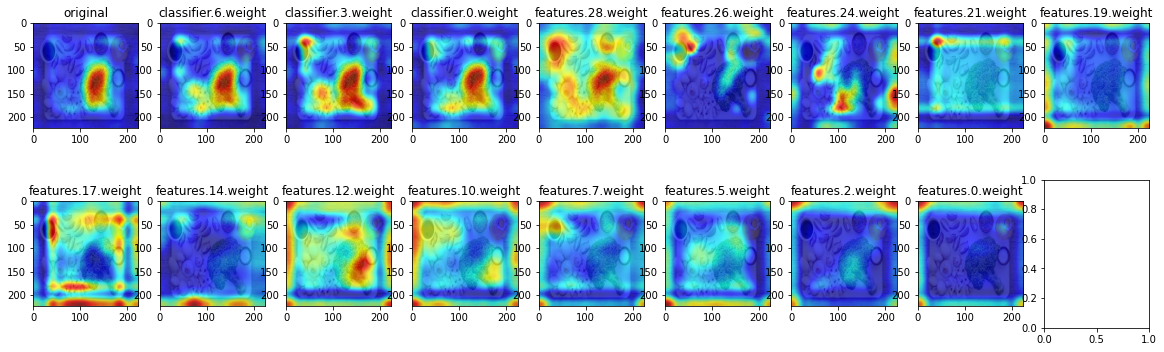

In [ ]:
indep_randomization(models.vgg16(pretrained=True), models.vgg16(pretrained=True), "broc-mush.jpg", class_idx=937, transform=transform)

predicted class:(868) tray

Randomizing: classifier.6.bias
Randomizing: classifier.6.weight
predicted class:(610) jersey, T-shirt, tee_shirt

Randomizing: classifier.4.bias
Randomizing: classifier.4.weight
predicted class:(463) bucket, pail

Randomizing: classifier.1.bias
Randomizing: classifier.1.weight
predicted class:(223) schipperke

Randomizing: features.10.bias
Randomizing: features.10.weight
predicted class:(676) muzzle

Randomizing: features.8.bias
Randomizing: features.8.weight
predicted class:(126) isopod

Randomizing: features.6.bias
Randomizing: features.6.weight
predicted class:(674) mousetrap

Randomizing: features.3.bias
Randomizing: features.3.weight
predicted class:(332) Angora, Angora_rabbit

Randomizing: features.0.bias
Randomizing: features.0.weight
predicted class:(904) window_screen



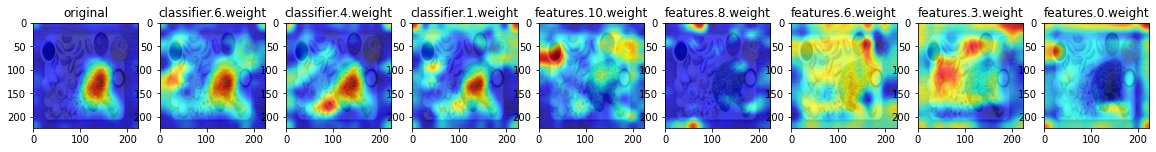

In [ ]:
indep_randomization(models.alexnet(pretrained=True), models.alexnet(pretrained=True), "broc-mush.jpg", class_idx=937, transform=transform)

### 1.1 AlexNet

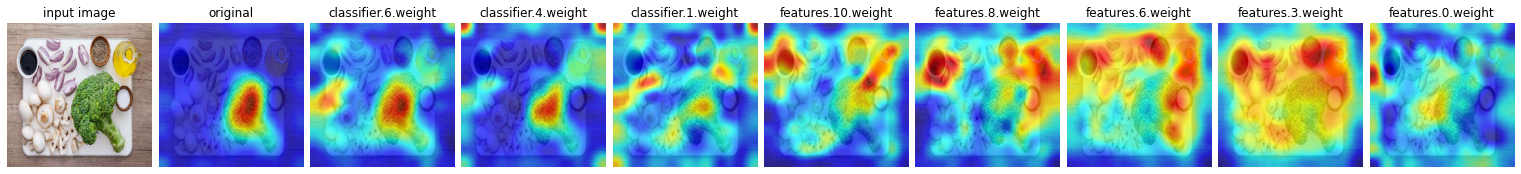

In [ ]:
cascading_randomization(models.alexnet(pretrained=True), "broc-mush.jpg", class_idx=937, transform=transform, map="gradcam")

### 1.2 VGG11

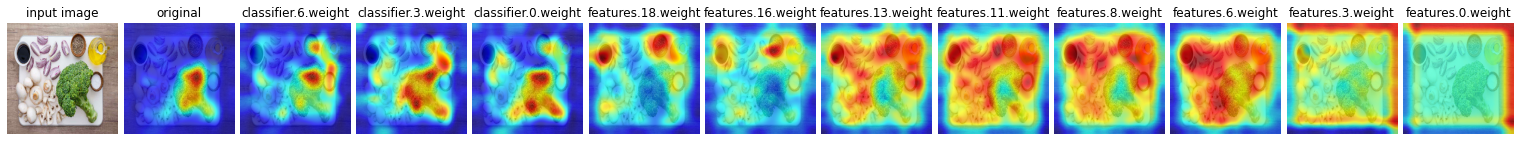

In [ ]:
cascading_randomization(models.vgg11(pretrained=True), "broc-mush.jpg", class_idx=937, transform=transform, map="gradcam")

## 2. SmoothGrad

### 2.1 AlexNet

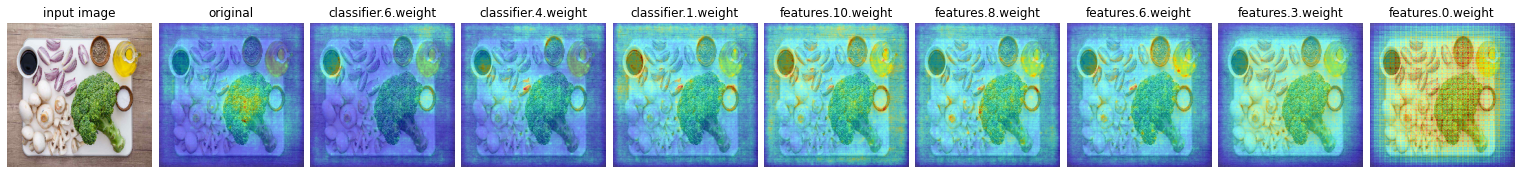

In [ ]:
cascading_randomization(models.alexnet(pretrained=True), "broc-mush.jpg", class_idx=937, transform=transform, map="smoothgrad", smoothGrad_std=25, smoothGrad_n=50)

### 2.2 VGG11

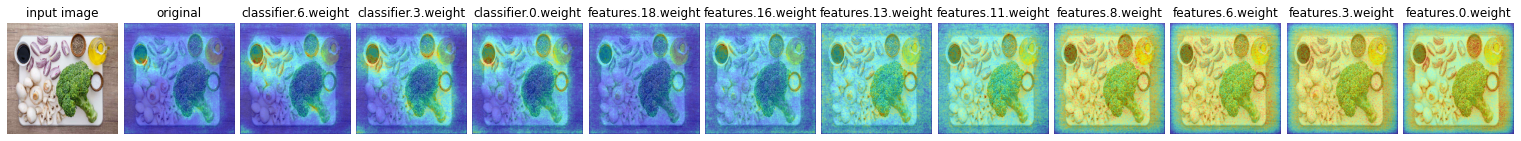

In [ ]:
cascading_randomization(models.vgg11(pretrained=True), "broc-mush.jpg", class_idx=937, transform=transform, map="smoothgrad", smoothGrad_std=25, smoothGrad_n=20)

# Detecting Bias in the Dataset


In [ ]:
!rm -r sample_data
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
var urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl')); var hiddenElement = document.createElement('a'); hiddenElement.href = 'data:text/csv;charset=utf-8,' + encodeURI(urls.join('\n')); hiddenElement.target = '_blank'; hiddenElement.download = 'myFile.csv'; hiddenElement.click();

In [ ]:
from fastai.vision import *
!mkdir male
csv_file = 'male.csv'
download_images(csv_file, Path("male/"), max_pics=1000)
!zip -qq -r male.zip male
!rm *csv

In [ ]:
!unzip -qq ofs_vs_ceo.zip
!ls ofs_vs_ceo/.DS_Store
!unzip -qq ofsMF_vs_ceo.zip
!ls ofs_vs_ceoMF/.DS_Store
!rm -r __MACOSX

ls: cannot access 'ofs_vs_ceo/.DS_Store': No such file or directory
ls: cannot access 'ofs_vs_ceoMF/.DS_Store': No such file or directory


## Helper Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, pickle, random
from PIL import Image, ImageFile
import pandas as pd
import seaborn as sns
from collections import OrderedDict, deque
from sklearn.metrics import confusion_matrix, classification_report
import cv2 
from google.colab.patches import cv2_imshow
from glob import glob
from urllib.request import urlretrieve

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

ImageFile.LOAD_TRUNCATED_IMAGES = True
use_cuda = torch.cuda.is_available()

transform = {
        'train' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(50),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
             
        'valid' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        }

In [ ]:
def train(n_epochs, 
          dataloaders, 
          model,  
          criterion, 
          use_cuda=True,
          lr=None,
          optimizer=None,
          freeze=True,
          start_e=0,
          one_hot_label=False):
    
    classes = dataloaders['train'].dataset.classes
    n_classes = len(classes)

    loss_dict = {}
    loss_dict['train'], loss_dict['valid'], loss_dict['valid_acc'] = [], [], []
    valid_loss_min = np.Inf
    prev_save = ""
    criterion = nn.MSELoss() if one_hot_label else criterion
    print("criterion: {}".format(criterion))
    for e in range(1, n_epochs + 1):
        start = time.time()
        if optimizer==None:
            if freeze:
                optimizer = optim.Adam(model.classifier[-1].parameters(), lr = lr[e-1])
            else:
                optimizer = optim.Adam(model.parameters(), lr = lr[e-1])
        train_loss, valid_loss, n_corr = 0., 0., 0
        
        ################# (1) TRAIN THE MODEL #################
        model.train()
        for data, target in dataloaders['train']:
            if use_cuda:
                data = data.cuda() 
                target = target.type(torch.FloatTensor).cuda() if one_hot_label else target.cuda()

            optimizer.zero_grad()
            output = model(data)    # [batch_size, n_classes]  (target: [batch_size])
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
                          
        ################# (2) VALIDATE THE MODEL #################
        model.eval()
        for data, target in dataloaders['valid']:
            if use_cuda:
                data = data.cuda() 
                target = target.type(torch.FloatTensor).cuda() if one_hot_label else target.cuda()

            output = model(data)    # [batch_size, n_classes]  (target: [batch_size])
            loss = criterion(output, target)
            
            valid_loss += loss.item()
            output = output.cpu().detach().numpy()
            if one_hot_label==False:
                n_corr += int(sum([np.argmax(pred)==target[i] for i, pred in enumerate(output)]))

        train_loss = train_loss/ len(dataloaders['train'].dataset)
        valid_loss = valid_loss/ len(dataloaders['valid'].dataset)
        loss_dict['train'].append(train_loss)
        loss_dict['valid'].append(valid_loss)

        if one_hot_label==False:
            valid_acc = n_corr/len(dataloaders['valid'].dataset)
            loss_dict['valid_acc'].append(valid_acc)
            print('Epoch: %d/%d\t Train Loss: %.5f\t Valid Loss: %.5f\t Valid Acc: %.4f\t elapsed time: %.1fs'%(e, n_epochs, train_loss, valid_loss, valid_acc, time.time()-start))
        else:
            print('Epoch: %d/%d\t Train Loss: %.5f\t Valid Loss: %.5f\t elapsed time: %.1fs'%(e, n_epochs, train_loss, valid_loss, time.time()-start))
        
        if valid_loss < valid_loss_min:
            if prev_save:
                os.remove("model" + prev_save + ".pt")
                os.remove("loss_dict" + prev_save + ".pkl")
            prev_save = "_" + str(start_e + e) 
            torch.save(model.state_dict(), "model" + prev_save + ".pt")
            pickle.dump(loss_dict, open("loss_dict" + prev_save + ".pkl", "wb"))
            valid_loss_min = valid_loss
            
    return model, loss_dict

In [ ]:
def plot_losses(loss_dict):
    plt.plot(loss_dict["train"])
    plt.plot(loss_dict["valid"])
    plt.ylabel("loss")
    plt.legend(["training loss", "valid loss"])
    plt.plot(loss_dict["valid_acc"])

In [ ]:
def define_model(model, n_classes, freeze=True):
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, n_classes)      
    if freeze:       
        for param in model.parameters():
            param.requires_grad = False  
        for param in model.classifier[-1].parameters():
            param.requires_grad = True 
    model = model.cuda()

    return model

In [ ]:
def unroll(module):
  if isinstance(module, torch.nn.modules.container.Sequential):
    return list(module.children())
  elif isinstance(module, torchvision.models.resnet.Bottleneck):
    return list(module.children())
  else:
    return [module]

def save_cnn_weights(module, cnn_weights, output):
  if isinstance(module, torch.nn.modules.conv.Conv2d):
    cnn_weights.append(output)
  return cnn_weights

In [ ]:
def gradCAM(img_path, model, labels, guided=False, class_idx=None, transform=None, 
            save_heatmap=None, print_cls=True, print_pred=True, 
            img_alpha=0.5, heatmap_alpha=0.5):
    '''
    PARAMETERS
      img           : image for which grad-CAM will be plotted
      model         : model for which grad-CAM will be plotted
      class_idx     : (int) idx of the class for which grad-CAM will be plotted
                      If None, the default predicted class will be used. 
    '''
    img_orig = Image.open(img_path).convert('RGB')
    torch.manual_seed(0)
    random.seed(0)
    img = transform(img_orig) if transform else transforms.ToTensor()(img_orig)
    img = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True)  # give a batch size of 1
    output = img
    if torch.cuda.is_available():
      output = output.cuda()

    cnn_i, sequential_i = 0, 0
    cnn_weights = []
    for module_pos, module in enumerate(model.children()):
      for i, m in enumerate(unroll(module)):
        if len(list(m.children())) == 0:
          output = m(output)
          cnn_weights = save_cnn_weights(m, cnn_weights, output)
          if isinstance(m, torch.nn.modules.pooling.AdaptiveAvgPool2d) :
            output = torch.flatten(output, 1)
        else:
          for ii, mm in enumerate(unroll(m)):
            output = mm(output)
            cnn_weights = save_cnn_weights(mm, cnn_weights, output)

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, (module_name, module) in enumerate(self.model._modules.items()):
            if module_pos < 9:
                x = module(x)  # Forward
                if int(module_pos) == self.target_layer:
                    x.register_hook(self.save_gradient)
                    conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    ### Step 1 ###
    # gradient of class c score (BEFORE softmax), wrt CNN feature map activations "layer weights"
    if class_idx is None:
      class_idx = torch.argmax(output, dim=-1).item()
    if print_cls:
      print("class:({})".format(class_idx), labels[class_idx])
    #predicted
    cls_idx = torch.argmax(output, dim=-1)  
    if print_pred:
      print("predicted class:({})".format(cls_idx.item()), labels[cls_idx.item()])
    grads = torch.autograd.grad(output[0, class_idx], cnn_weights[-1], retain_graph=True)
    grads = grads[0].squeeze(0)  # [n_filtermap, W_lastCNN, H_lastCNN]
    if guided:
      # Target for backprop
      one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
      one_hot_output[0][class_idx] = 1
      grads_guided = torch.autograd.grad(one_hot_output, img, retain_graph=True)
      grads_guided = grads_guided[0].squeeze(0)
      # Backward pass
      #output.backward(gradient=one_hot_output)
      # Convert Pytorch variable to numpy array
      # [0] to get rid of the first channel (1,3,224,224)
      #gradients_as_arr = self.gradients.data.numpy()[0]
      grads_guided = torch.clamp(grads_guided, min=0.).detach().numpy()

    ### Step 2 ###
    grads_avgpooled = torch.mean(grads, axis=(1,2))  # [n_filtermap] 
    grads_avgpooled = grads_avgpooled.expand_as(cnn_weights[-1].squeeze(0).permute(1,2,0))
    grads_avgpooled = grads_avgpooled.permute(2,0,1)

    ### Step 3 : ReLU of Linear Combination ### 
    map = nn.ReLU()(grads_avgpooled*cnn_weights[-1].squeeze(0))   # layer_weights shape
    map = torch.sum(map, dim=0)  # [W_lastCNN, H_lastCNN]
    map = map.cpu().detach().numpy() if torch.cuda.is_available() else map.detach().numpy()
    map_interpolated = np.array(cv2.resize(map, dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC))

    ### Step 4 ###
    map_interpolated = cv2.resize(map, dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC)
    # make color heatmap
    heatmap = cv2.normalize(map_interpolated, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay heatmap on top of the image
    img_ = cv2.imread(img_path, 1)
    img_ = cv2.resize(img_, dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC)
    fin = cv2.addWeighted(img_, img_alpha, heatmap, heatmap_alpha, 0)

    return class_idx, fin[:,:,::-1]

In [ ]:
def calcImageGrad(image_tensor, model, cls=None):
  image = image_tensor
  model.eval()
  image.requires_grad_()
  output = model(image.cuda())
  output_max_index = output[0].argmax() if cls==None else cls
  #print(output[0])
  output_max = output[0, output_max_index]
  output_max.backward()

  return torch.max(image.grad.data.abs(), dim=1)[0]


  
def smoothGrad(img_path, stdev, n, model, cls=None):
  image = Image.open(img_path)
  preprocessing = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  no_norm = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()
  ])
  image_processed = preprocessing(image)
  image_final = image_processed.reshape(1,3,224,224)#.cuda()
  image_final.requires_grad_()

  grad_stdev = float((stdev/100)*(torch.max(image_final[0])-torch.min(image_final[0])))
  print("standard dev: ", grad_stdev)
  total =  torch.from_numpy(np.zeros(image_final.shape))
  image_tensor = image_final

  for i in range(n):
    print_progress(i,n)
    size = image_final.shape
    input_image = (image_tensor.detach() + np.random.normal(0,grad_stdev, size = size)).float()
    input_image.requires_grad_()
    image_grad = calcImageGrad(input_image, model, cls=cls)
    total = total+image_grad

  saliency = (total/n)[0]
  # make color heatmap
  heatmap = cv2.normalize(saliency.numpy()[0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # overlay heatmap on top of the image
  img_ = cv2.imread(img_path, 1)
  img_ = cv2.resize(img_, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
  img_alpha, heatmap_alpha = 0.5, 0.6
  fin = cv2.addWeighted(img_, img_alpha, heatmap, heatmap_alpha, 0)
  plt.imshow(fin[...,::-1])
  plt.axis('off')
  plt.show()

  return saliency

def print_progress(i,n):
  if i == 0:
    print("_"*n)
  if i>=n:
    return
  else:
    print("-", end = "")

In [ ]:
def test_model(model, transform, img_dir, classes=None):
    model.cuda()
    model.eval()
    n_pred_ceo = 0
    for img_path in os.listdir(img_dir):
      img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')     
      img = transform(img)[:3, :, :].unsqueeze(0)    
      img = img.cuda() if use_cuda else img
      with torch.no_grad():
        logits = model(img)  # [batch, n_classes]
        logits = logits.cpu().detach().numpy()[0]
      #pred = [1 if prob==max(logits) else 0 for prob in logits]
      #cm[1] += pred
      n_pred_ceo = n_pred_ceo + 1 if np.argmax(logits)==0 else n_pred_ceo
    n_test = len(os.listdir(img_dir))
    print("{} out of {} male office secretary images are classified as CEO.".format(n_pred_ceo, n_test))
    print("test accuracy of :", (n_test-n_pred_ceo)/n_test)

## Original Dataset (unbalanced)

In [ ]:
root_dir = "ofs_vs_ceo/"  # 2 classes
train_data = datasets.ImageFolder(root_dir + 'train', transform = transform['train'])
valid_data = datasets.ImageFolder(root_dir + 'valid', transform = transform['valid'])
#test_data = datasets.ImageFolder(root_dir + 'test', transform = transform['valid'])
print("Classes: ", train_data.classes)
print("Class2idx: ", train_data.class_to_idx)
print('Train images :', len(train_data))
print('Valid images :', len(valid_data))
#print('Test images :', len(test_data))
num_workers = 0
batch_size = 64
dataloaders = {}
dataloaders['train'] = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
dataloaders['valid'] = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
#dataloaders['test'] = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

Classes:  ['CEO', 'office_secretary']
Class2idx:  {'CEO': 0, 'office_secretary': 1}
Train images : 337
Valid images : 38


In [ ]:
alex = define_model(model=models.alexnet(pretrained=True), n_classes=2, freeze=False)
lr = [0.00001]*10 + [0.00005]*8 + [0.00003]*7
alex, loss_dict = train(n_epochs=10, 
                          dataloaders=dataloaders, 
                          model=alex, 
                          criterion=nn.CrossEntropyLoss(),
                          lr=lr,
                          freeze=False)

criterion: CrossEntropyLoss()
Epoch: 1/10	 Train Loss: 0.01282	 Valid Loss: 0.01757	 Valid Acc: 0.6579	 elapsed time: 1.4s
Epoch: 2/10	 Train Loss: 0.00994	 Valid Loss: 0.01444	 Valid Acc: 0.7632	 elapsed time: 1.4s
Epoch: 3/10	 Train Loss: 0.00824	 Valid Loss: 0.01249	 Valid Acc: 0.7895	 elapsed time: 1.5s
Epoch: 4/10	 Train Loss: 0.00687	 Valid Loss: 0.01125	 Valid Acc: 0.8421	 elapsed time: 1.4s
Epoch: 5/10	 Train Loss: 0.00624	 Valid Loss: 0.01020	 Valid Acc: 0.8947	 elapsed time: 1.4s
Epoch: 6/10	 Train Loss: 0.00555	 Valid Loss: 0.00953	 Valid Acc: 0.9211	 elapsed time: 1.4s
Epoch: 7/10	 Train Loss: 0.00461	 Valid Loss: 0.00915	 Valid Acc: 0.8947	 elapsed time: 1.4s
Epoch: 8/10	 Train Loss: 0.00417	 Valid Loss: 0.00908	 Valid Acc: 0.8947	 elapsed time: 1.5s
Epoch: 9/10	 Train Loss: 0.00346	 Valid Loss: 0.00901	 Valid Acc: 0.8947	 elapsed time: 1.5s
Epoch: 10/10	 Train Loss: 0.00338	 Valid Loss: 0.00872	 Valid Acc: 0.8947	 elapsed time: 1.5s


In [ ]:
!unzip -qq male_test.zip

In [ ]:
test_model(alex, transform['valid'], img_dir="male_test")

7 out of 16 male office secretary images are classified as CEO.
test accuracy of : 0.5625


class:(0) CEO
predicted class:(0) CEO


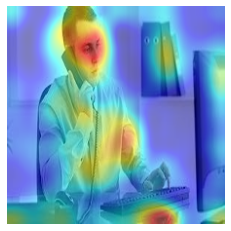

In [ ]:
_, h = gradCAM("male_test/00000014.jpg", alex, labels=['CEO','Office Secretary'], transform=transform['valid'])
plt.imshow(h)
plt.axis("off")
plt.show()

standard dev:  1.1723512411117554
__________________________________________________
--------------------------------------------------

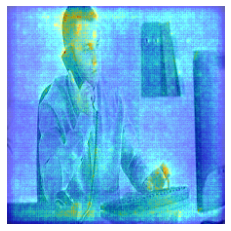

In [ ]:
saliency = smoothGrad('male_test/00000014.jpg', 25, 50, alex, cls=1)

In [ ]:
torch.save(alex.state_dict(), "alex.pt")
!cp "alex.pt" gdrive/MyDrive/

## After Balancing the Dataset

In [ ]:
root_dir = "ofsMF_vs_ceo/"  # 2 classes
train_data = datasets.ImageFolder(root_dir + 'train', transform = transform['train'])
valid_data = datasets.ImageFolder(root_dir + 'valid', transform = transform['valid'])
print("Classes: ", train_data.classes)
print("Class2idx: ", train_data.class_to_idx)
print('Train images :', len(train_data))
print('Valid images :', len(valid_data))
num_workers = 0
batch_size = 64
dataloaders = {}
dataloaders['train'] = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
dataloaders['valid'] = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

Classes:  ['CEO', 'office_secretary']
Class2idx:  {'CEO': 0, 'office_secretary': 1}
Train images : 368
Valid images : 43


In [ ]:
alex_balanced = define_model(model=models.alexnet(pretrained=True), n_classes=2, freeze=False)
lr = [0.00001]*10 + [0.00005]*8 + [0.00003]*7
alex_balanced, loss_dict = train(n_epochs=15, 
                                dataloaders=dataloaders, 
                                model=alex_balanced, 
                                criterion=nn.CrossEntropyLoss(),
                                lr=lr,
                                freeze=False)

criterion: CrossEntropyLoss()
Epoch: 1/15	 Train Loss: 0.01142	 Valid Loss: 0.01184	 Valid Acc: 0.7674	 elapsed time: 1.5s
Epoch: 2/15	 Train Loss: 0.00871	 Valid Loss: 0.00981	 Valid Acc: 0.8372	 elapsed time: 1.5s
Epoch: 3/15	 Train Loss: 0.00734	 Valid Loss: 0.00850	 Valid Acc: 0.8605	 elapsed time: 1.5s
Epoch: 4/15	 Train Loss: 0.00648	 Valid Loss: 0.00758	 Valid Acc: 0.8837	 elapsed time: 1.5s
Epoch: 5/15	 Train Loss: 0.00563	 Valid Loss: 0.00698	 Valid Acc: 0.8837	 elapsed time: 1.5s
Epoch: 6/15	 Train Loss: 0.00452	 Valid Loss: 0.00658	 Valid Acc: 0.9070	 elapsed time: 1.5s
Epoch: 7/15	 Train Loss: 0.00439	 Valid Loss: 0.00633	 Valid Acc: 0.9070	 elapsed time: 1.5s
Epoch: 8/15	 Train Loss: 0.00442	 Valid Loss: 0.00616	 Valid Acc: 0.9070	 elapsed time: 1.5s
Epoch: 9/15	 Train Loss: 0.00446	 Valid Loss: 0.00593	 Valid Acc: 0.9070	 elapsed time: 1.5s
Epoch: 10/15	 Train Loss: 0.00361	 Valid Loss: 0.00573	 Valid Acc: 0.9070	 elapsed time: 1.5s
Epoch: 11/15	 Train Loss: 0.00336	 Vali

In [ ]:
test_model(alex_balanced, transform['valid'], img_dir="male_test")

3 out of 16 male office secretary images are classified as CEO.
test accuracy of : 0.8125


class:(1) Office Secretary
predicted class:(1) Office Secretary


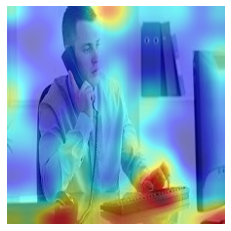

In [ ]:
_, h = gradCAM("male_test/00000014.jpg", alex_balanced, labels=['CEO','Office Secretary'], transform=transform['valid'])
plt.imshow(h)
plt.axis("off")
plt.show()

standard dev:  1.4068214893341064
__________________________________________________
--------------------------------------------------

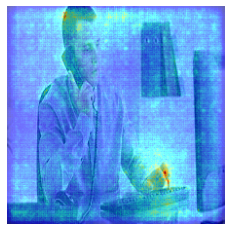

In [ ]:
saliency = smoothGrad('male_test/00000014.jpg', 30, 50, alex_balanced, cls=1)

In [ ]:
torch.save(alex_balanced.state_dict(), "alex_balanced.pt")
!cp "alex_balanced.pt" gdrive/MyDrive/